**IMPORTING NECESSARY LIBRARIES**

In [1]:
# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

import os
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
le = LabelEncoder()

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

**LOADING DATA**

In [2]:
data = pd.read_csv('data/UrbanSound8K.csv')
print(data.shape)
data.head()

(8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
data.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


**PLOTTING COUNT DISTRIBUTION OF CLASSES**

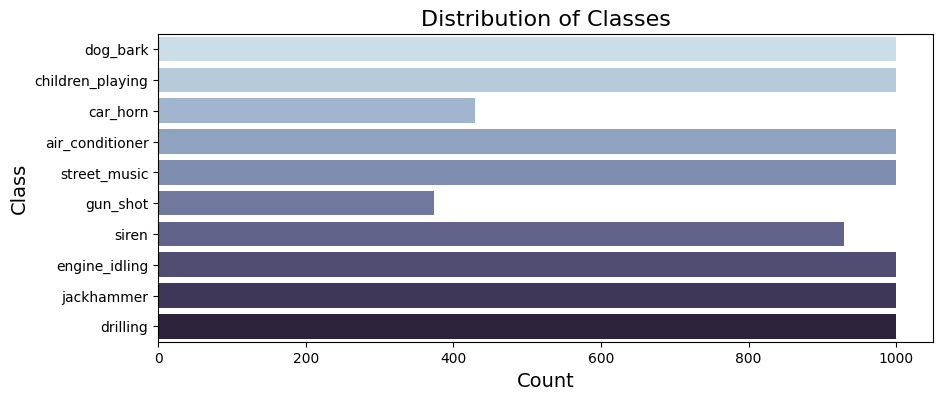

In [5]:
plt.figure(figsize = (10, 4))
sns.countplot(y = data['class'], palette = 'ch:s=.25,rot=-.25')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

**LOADING AUDIO FILES**

Using Librosa, loading all of the audio files in our dataset and storing the audio files and labels in lists. so that it can be used later for feature extracting and modeling.

In [6]:
# Load the labels from the csv file
label_dict = {}
with open("data/UrbanSound8K.csv") as f:
    reader = csv.reader(f)
    next(reader)  # skip header row
    for row in reader:
        filename = row[0]
        label = row[7]  # label is in the 8th column (index 7)
        label_dict[filename] = label

print(label_dict)

{'100032-3-0-0.wav': 'dog_bark', '100263-2-0-117.wav': 'children_playing', '100263-2-0-121.wav': 'children_playing', '100263-2-0-126.wav': 'children_playing', '100263-2-0-137.wav': 'children_playing', '100263-2-0-143.wav': 'children_playing', '100263-2-0-161.wav': 'children_playing', '100263-2-0-3.wav': 'children_playing', '100263-2-0-36.wav': 'children_playing', '100648-1-0-0.wav': 'car_horn', '100648-1-1-0.wav': 'car_horn', '100648-1-2-0.wav': 'car_horn', '100648-1-3-0.wav': 'car_horn', '100648-1-4-0.wav': 'car_horn', '100652-3-0-0.wav': 'dog_bark', '100652-3-0-1.wav': 'dog_bark', '100652-3-0-2.wav': 'dog_bark', '100652-3-0-3.wav': 'dog_bark', '100795-3-0-0.wav': 'dog_bark', '100795-3-1-0.wav': 'dog_bark', '100795-3-1-1.wav': 'dog_bark', '100795-3-1-2.wav': 'dog_bark', '100852-0-0-0.wav': 'air_conditioner', '100852-0-0-1.wav': 'air_conditioner', '100852-0-0-10.wav': 'air_conditioner', '100852-0-0-11.wav': 'air_conditioner', '100852-0-0-12.wav': 'air_conditioner', '100852-0-0-13.wav':

In [7]:
# Load the audio files and labels
audio_files = []
labels = []

# Loop through all the folders in the directory
for foldername in os.listdir("data/audio_data"):
    if foldername == '.DS_Store':  # skip .DS_Store file
        continue
    # print(foldername)

    # Loop through all the audio files in the folder
    for filename in os.listdir("data/audio_data/{}".format(foldername)):
        # Load the audio file
        data, sr = librosa.load("data/audio_data/{}/{}".format(foldername, filename), sr=None)
        
        # Get the label for the audio file
        label = label_dict[filename]
        
        audio_files.append((data, sr))
        labels.append(label)

print(audio_files[:2])
print(labels[:2])

[(array([ 0.00121522,  0.00665033,  0.00564677, ..., -0.02288371,
       -0.01937652, -0.01288444], dtype=float32), 44100), (array([-0.1511383 , -0.17538452, -0.19085693, ...,  0.11982727,
        0.11242676,  0.11875916], dtype=float32), 44100)]
['jackhammer', 'street_music']


**AUDIO VISUALIZATION - WAVE & SPECTOGRAM**

One audio sample each category as a wave and a spectogram to have a better insight of the classes and the differences.

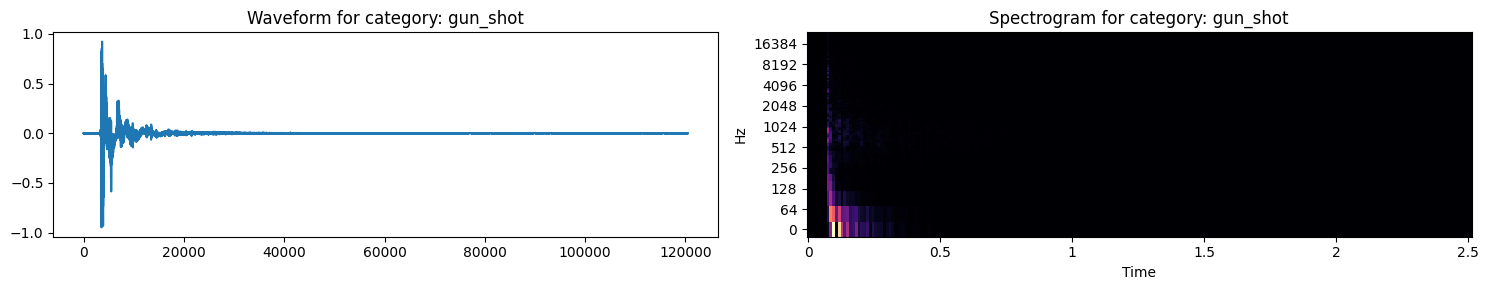

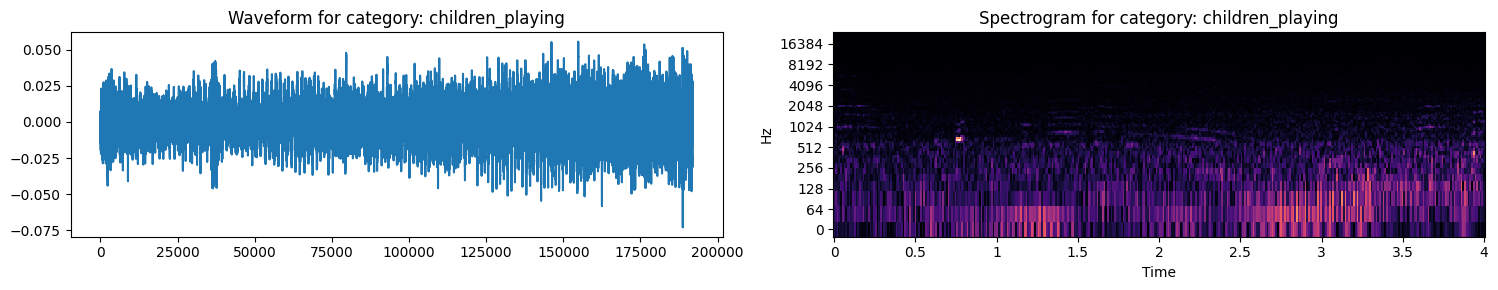

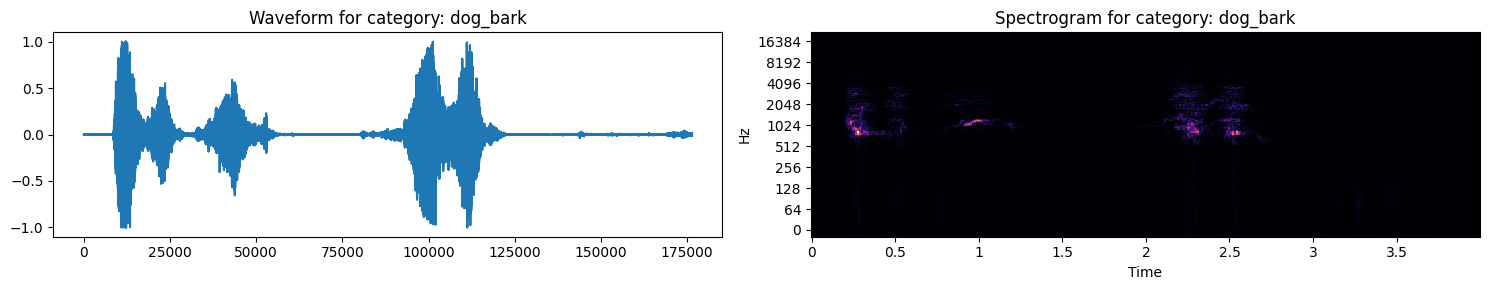

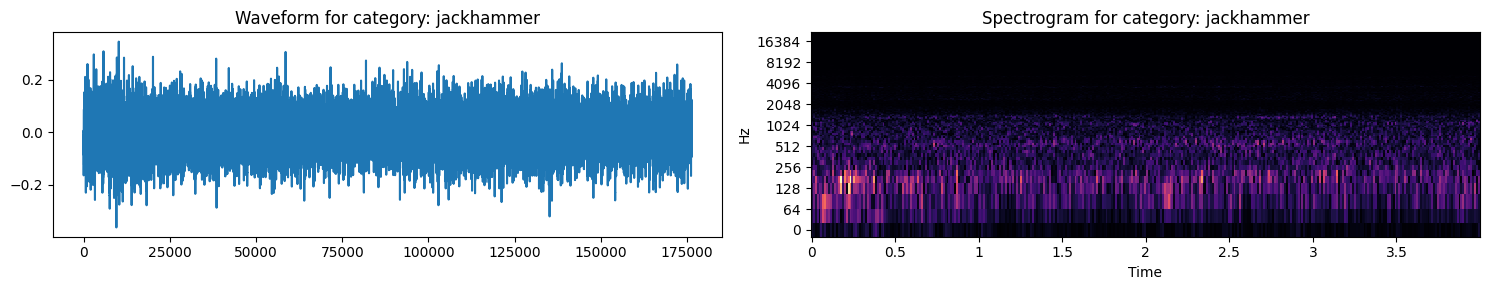

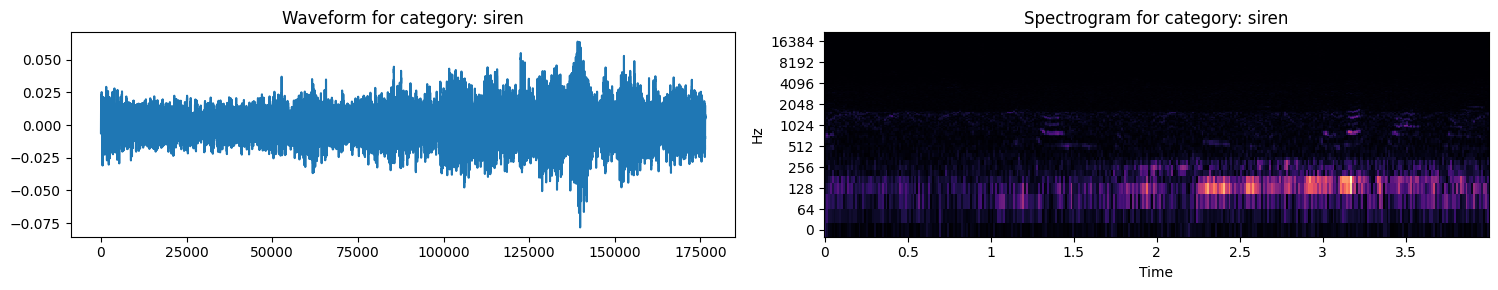

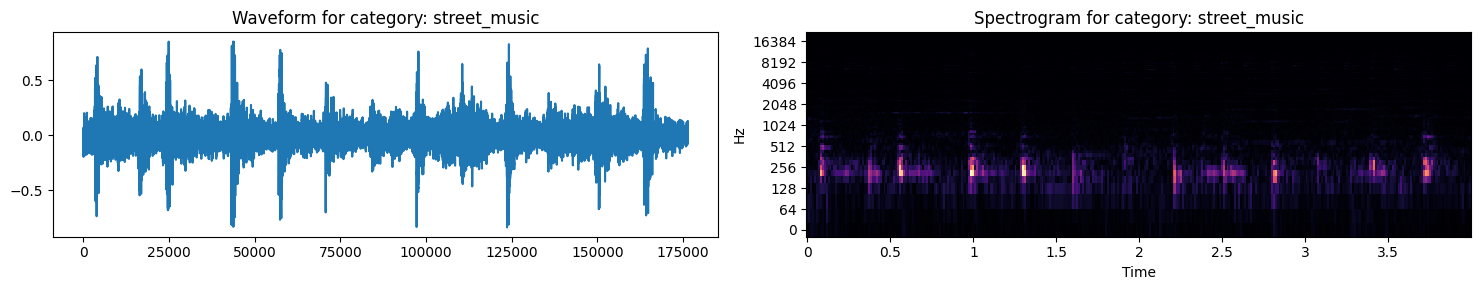

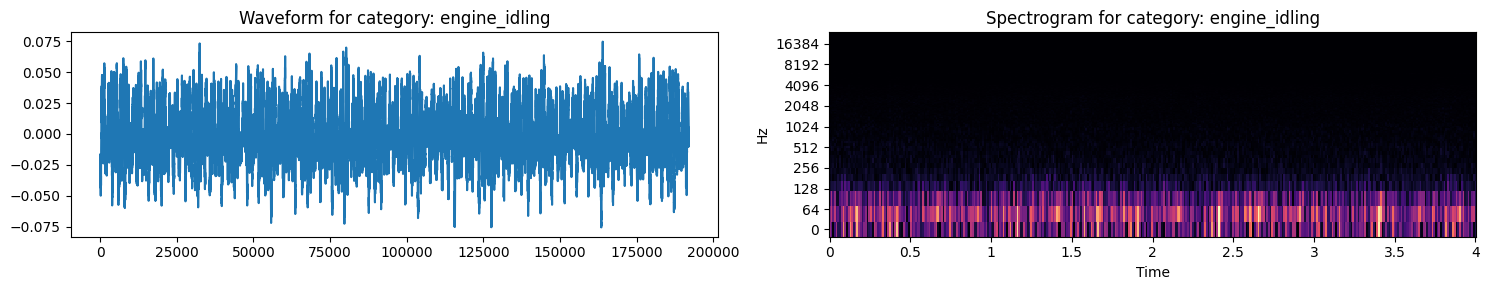

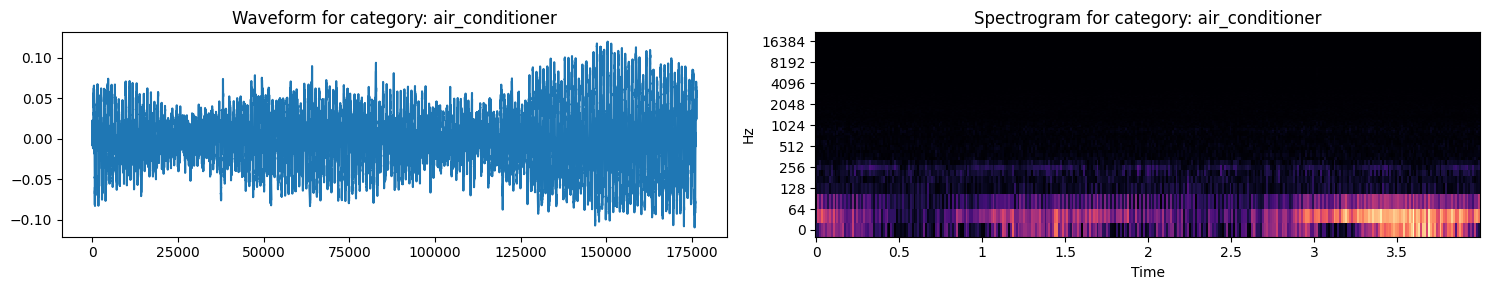

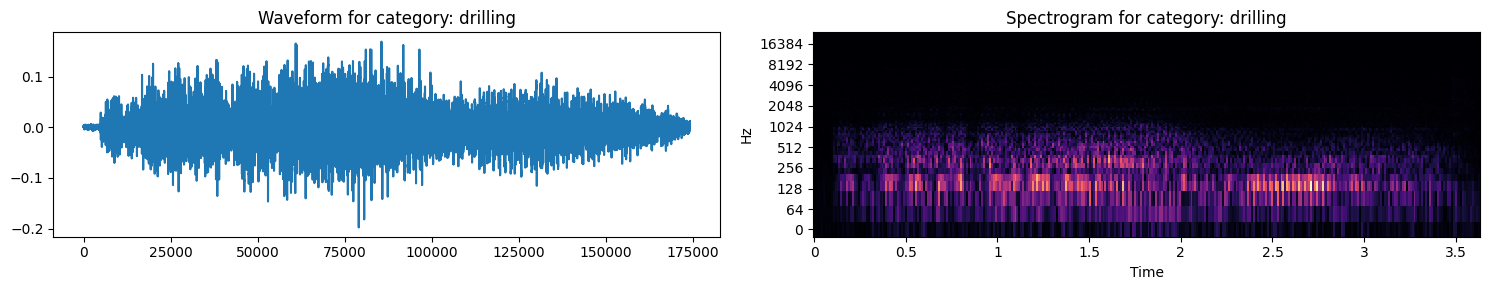

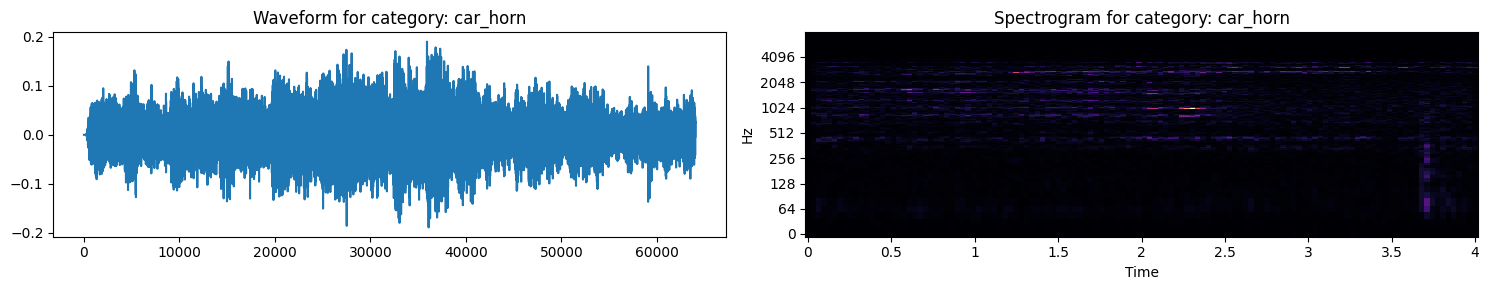

In [8]:
# Loop through all the categories
for category in set(labels):
    # Find an audio file in the category
    index = labels.index(category)
    data, sr = audio_files[index]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    
    # Plot the waveform
    ax1.plot(data)
    ax1.set_title("Waveform for category: {}".format(category))
    
    # Compute and plot the spectrogram
    S = librosa.core.stft(data, n_fft=1024, hop_length=512)
    spectrogram = np.abs(S)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='log', ax=ax2)
    ax2.set_title("Spectrogram for category: {}".format(category))
    
    fig.tight_layout()
    plt.show()


**FEATURE EXTRACTION - MFCCs**


**Mel-frequency cepstral coefficients (MFCCs)** are a set of features that capture the spectral characteristics of an audio signal. They are commonly used in speech and music processing. MFCCs are typically used to represent the spectral envelope of an audio signal, which is a summary of the spectral content of the signal over time. They are useful for tasks such as speaker recognition, speech recognition, and music classification, as they capture the spectral characteristics of the signal that are relevant to these tasks.

In [9]:
X = []
max_length = 0
for data, sr in audio_files:
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T,axis=0)
    X.append(mfccs_scaled)

print(X[0])

[-2.36121490e+02  2.37696655e+02 -4.84007263e+01  3.53577461e+01
 -1.47442427e+01 -1.56869354e+01  6.78507710e+00  6.78954935e+00
  1.12675552e+01 -1.43413315e+01 -5.89658308e+00  1.09831524e+00
  2.87737513e+00  8.25252151e+00 -6.95670795e+00 -3.21128201e+00
  2.03277564e+00 -3.12855899e-01  1.10065319e-01 -6.53912640e+00
 -5.24561453e+00  3.46445709e-01 -7.84007967e-01 -9.63514614e+00
 -2.84931397e+00  3.99986243e+00 -4.52129698e+00 -4.18474865e+00
 -2.02512956e+00 -3.16412830e+00 -1.21166158e+00  3.01609874e+00
 -1.09210241e+00 -6.85414457e+00 -1.64517307e+00 -1.41291773e+00
 -2.17761731e+00  1.12006283e+00 -1.56648815e+00 -8.65696490e-01]


**SCALING & ENCODING**

In [10]:
# Scaling
X = scaler.fit_transform(X)

# One-Hot encoding
y = labels
y = le.fit_transform(labels)

In [11]:
print(X[0])
print(X[0].shape)
print(y[0])

[ 0.37051315  1.66196419 -0.45968974  0.5422961  -0.25475853 -1.58001183
  0.73353542  0.01412538  1.05871644 -1.84298775 -0.53837789 -0.06031286
  0.39298047  1.01365781 -1.02789638 -0.57372391  0.38127158 -0.18221035
  0.07265089 -1.294244   -0.85965345  0.04462823 -0.04676978 -2.03431105
 -0.43751532  0.9259166  -0.84302721 -0.99506224 -0.35177476 -0.83059111
 -0.1453193   0.92070697 -0.09212301 -1.88913166 -0.29385175 -0.45225392
 -0.3350586   0.43314868 -0.37638574 -0.30113204]
(40,)
7


In [12]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6985, 40) (6985,)
(1747, 40) (1747,)


**MODELS**

In [13]:
# Define the classifiers to use
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=100, criterion='gini'),
    AdaBoostClassifier(n_estimators=200, learning_rate=0.1),
    GradientBoostingClassifier(n_estimators=300, learning_rate=0.1),
    SGDClassifier(),
    MLPClassifier(),
    XGBClassifier()
]

# List to store the results
results_list = []

# Loop through the classifiers
for clf in classifiers:
    # Fit the classifier to the training data
    clf.fit(x_train, y_train)
    
    # Evaluate the classifier on the test data
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    
    # Store the results in a dictionary
    results_list.append({
        'Classifier': clf.__class__.__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    })

# Create the DataFrame from the list
results = pd.DataFrame(results_list)

# Sort the DataFrame by the Accuracy column in descending order
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# show the DataFrame
results

,Classifier,Accuracy,Precision,Recall
6,XGBClassifier,0.905552,0.914316,0.900511
1,RandomForestClassifier,0.904408,0.919479,0.895612
5,MLPClassifier,0.888952,0.890903,0.889959
0,KNeighborsClassifier,0.886090,0.888701,0.884878
3,GradientBoostingClassifier,0.862622,0.870821,0.858016
4,SGDClassifier,0.548369,0.548437,0.525789
2,AdaBoostClassifier,0.469376,0.511406,0.431662
